# Загрузка Pandas и очистка данных

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import collections
import re
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/modul_3/main_task.xls')
df_population = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/modul_3/worldcities.csv')

## population

In [4]:
# Переимнунуем правельное название города. По остальным все ок.
df.loc[df.City == 'Oporto', 'City'] = 'Porto'
city_lst = df.City.unique() # создадим список тех городов по которым нам нужно получить доп. данные.

In [5]:
# Отфильтруем данные от лишних стран.
df_population = df_population[(df_population.city.isin(city_lst)) &
                  (df_population.country != 'United States') &
                  (df_population.country != 'Canada') &
                  (df_population.country != 'Venezuela')]

In [6]:
# Проверяем все ли города у нас есть в доп. датафрейме
set(city_lst) - set(df_population.city) # 

{'Krakow', 'Zurich'}

In [7]:
# Переименуем в доп. дата фрейме колонку City
df_population.rename(columns={'city':'City'}, inplace=True)
# Выбераем нужные столбцы
df_population = df_population[['City','population']]

In [8]:
# Сливаем оба дата фрейма в один
df = df.merge(df_population, how = 'left', on = 'City')

In [9]:
# Заполним population где города Zurich, Krakow т.к. их не было в наших данных
df.loc[df.City == 'Krakow', 'population'] = 779115.0
df.loc[df.City == 'Zurich', 'population'] = 434008.0

In [10]:
df['population']  = round((df['population'] / 1000000), 2)

## 'ID_TA'

In [11]:
# Просто преобразуем в int и посмотрим что, выдаст
df['ID_TA'] = df['ID_TA'].apply(lambda x: int(x[1:]))

## Price Range

In [12]:

df['Price Range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: Price Range, dtype: int64

In [13]:
df['Price Range'].fillna(df['Price Range'].mode()[0], inplace=True)
price_dict = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
df['Price Range'] = df['Price Range'].map(price_dict)

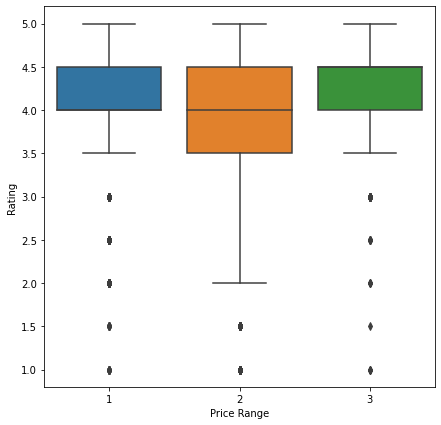

In [14]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.boxplot(x='Price Range', y='Rating', data=df, ax=ax)

## Ranking

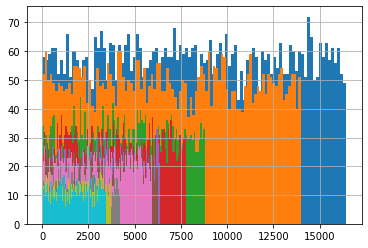

In [15]:
# посмотрим на топ 10 городов
for x in (df['City'].value_counts())[0:10].index:
    df['Ranking'][df['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

In [16]:
# Создадим новый признак количество ресторанов в городе
city_counts_dict = dict(df['City'].value_counts())
df['rest_counts'] = df.City.map(city_counts_dict)

In [17]:
# Разделив Ranking — место, которое занимает данный ресторан среди всех ресторанов cвоего города на количество ресторанов(rest_counts), мы уберем смещение.
df['rank_city'] = df.Ranking / df.rest_counts

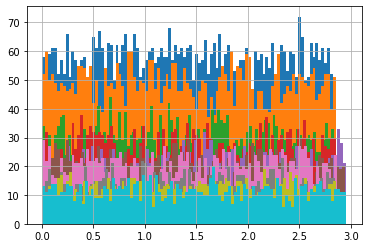

In [18]:
# Снова посмотрим на топ 10 городов
for x in (df['City'].value_counts())[0:10].index:
    df['rank_city'][df['City'] == x].hist(bins=100)
plt.show()

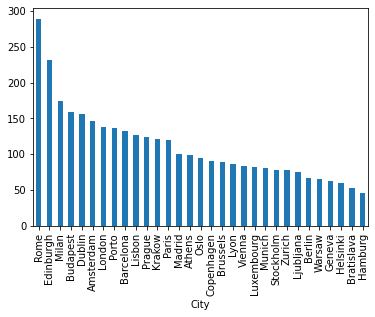

In [19]:
# Смотрим среднее количество отзывов по городам
df.groupby('City')['Number of Reviews'].mean().sort_values(ascending=False).plot(kind='bar')

In [20]:
dic = dict(df.groupby('City')['Number of Reviews'].mean()) # / кол-во населения
df['count_rew'] = df.City.map(dic)

Cuisine Style

In [21]:
# Заменим пробелы на 'other' и  удалим не нужные символы 
df['Cuisine Style'].fillna("['Other']", inplace=True)
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: eval(x)) # получили столбец со списками

Соберем все рестораны в коллекцию. Она нам пригодится для создания новых признаков

In [22]:
c = collections.Counter()
all_cuisune = set()
for row in df['Cuisine Style']:
  for i in row:
    c[i] +=1
    all_cuisune.add(i)
all_cuisune_lst = list(all_cuisune)
print(len(c)-1) # отнимем 'other' 

125


In [23]:
df.explode('Cuisine Style')['Cuisine Style'].nunique() # explode Transform each element of a list-like to a row, replicating index values.

126

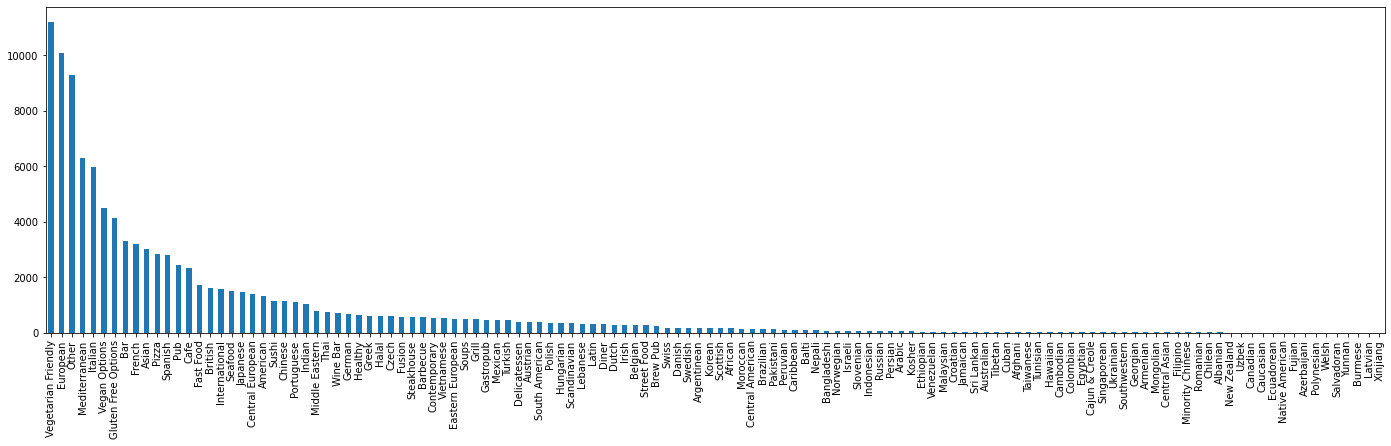

In [24]:
# Посмотрим на популярность кухонь
plt.figure(figsize=(24,6))
df.explode('Cuisine Style')['Cuisine Style'].value_counts(ascending=False).plot(kind='bar');

Мы получили всего 125 кухонь - для создания новых признаков это слишком много. Отсеим наименее распространенные кухни. 

In [25]:
kitches = dict(c)
kitches_by_350 = [i for i in kitches if kitches[i] > 350]
len(kitches_by_350)

49

Создадим функцию для заполнения значения в каждой ячейке. Функция будет проверять наличие конкретной кухни в столбце 'Cuisine Style' для текущего ресторана и возвращать 1, если кухня есть в ресторане, и 0, если отсутствует. Организуем цикл с параметром, в котором будем перебирать наименования всех кухонь (kitches_by_350). Для каждой кухни создадим в датафрейме столбец с соответствующим названием и заполним его единичками и нулями, применив к датафрейму, а точнее, к столбцу 'Cuisine Style', функцию, созданную нами на предыдущем шаге. Код функции, с помощью которой мы будем создавать новые столбцы и заполнять их значениями, могут выглядеть следующим образом:

In [26]:
def find_item(cell):
    if item in cell:
        return 1
    return 0

for item in kitches_by_350:
    df[item] = df['Cuisine Style'].apply(find_item)

Кухонь которых меньше 350 закинем в один столбец для этого создадим функцию которая, будет возвращать количеств редких кухонь в каждом ресторане.

In [27]:
kitches_rare = [i for i in kitches if kitches[i] <= 350]
def kitch_count(cell):
    x = 0
    for i in kitches_rare:
        if i in cell:
            x += 1
    return x
df['kitch_rare'] = df['Cuisine Style'].apply(kitch_count)

In [28]:
df['kitch_rare'].value_counts()

0    35175
1     3899
2      840
3       74
4       11
7        1
Name: kitch_rare, dtype: int64

Теперь мы можем заменить в 'Cuisine Style' название кухни на их количество. Таким образом мы создадим еще один признак.

In [29]:
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: len(x))

Теперь посмотрим сколько городв у нас представлено.

In [30]:
df['City'].value_counts()

London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Porto          513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: City, dtype: int64

в каком городе кухня ресторанов более разнообразна

Создадим новые признаки по городам.

In [31]:
df = pd.get_dummies(df, columns=['City']) 
df.head(2)

,Restaurant_id,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,population,rest_counts,rank_city,count_rew,European,French,International,Other,Japanese,Sushi,Asian,Grill,Vegetarian Friendly,Vegan Options,Gluten Free Options,German,Central European,Italian,Pizza,Fast Food,Mediterranean,Spanish,Healthy,Cafe,Thai,Vietnamese,Bar,Pub,Chinese,British,Polish,...,Hungarian,Delicatessen,Eastern European,Czech,American,Austrian,Halal,Gastropub,kitch_rare,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oslo,City_Paris,City_Porto,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
0,id_5569,3,5570.0,3.5,2,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,1912643,9.90,4897,1.137431,120.146373,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,id_1535,1,1537.0,4.0,2,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,7992032,1.26,820,1.874390,77.935356,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Reviews

In [32]:
# Перед тем как удалить пропуски создадим доп признак по отсутствию пропусков, т.к. отсутствие информации может быть важным признаком!
df['Number_of_Reviews_isNAN'] = pd.isna(df['Number of Reviews']).astype('uint8')

In [33]:
df['Reviews'][0]

"[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]"

In [34]:
# обработаем колонку Reviews
df['Reviews'] = df.Reviews.dropna().apply(lambda x: eval(x.replace('nan', '').replace('[,', "['',"))) 

In [35]:
# df['Reviews'] = df['Reviews'].dropna().apply(
    # lambda x: np.nan if len(x[0]) == 0 & len(x[1]) == 0 else x)

In [36]:
df['date'] = df['Reviews'].dropna().apply(lambda x: x[1]) # берем из списка даты
df['date_1'] = df['date'].dropna().apply(lambda x: x[1] if len(x) == 2 else np.nan) # если в списке 2 даты берем вторую
df['date_2'] = df['date'].dropna().apply(lambda x: x[0] if len(x) > 0 else np.nan) # берем первую

In [37]:
df.drop('date', axis=1, inplace=True) # удалим столбец date 

In [38]:
# переведем в datetime
df['date_1'] = pd.to_datetime(df['date_1'])
df['date_2'] = pd.to_datetime(df['date_2'])

In [39]:
df['date_1'].fillna(df['date_1'].mean(), inplace=True)
df['date_2'].fillna(df['date_2'].mean(), inplace=True)

In [40]:
# количиство дней между отзывами
df['days'] = abs(df['date_2'] - df['date_1']).dt.days

In [41]:
# Посчитаем сколько дней прошло с последнего отзыва до наст. времени
def days(day_1, day_2):
  dt_now = datetime.today()
  if not day_1 or not day_2:
    return 0
  if day_1 > day_2:
    return (dt_now - pd.to_datetime(day_1)).days
  return (dt_now - pd.to_datetime(day_2)).days

df['days_now'] = df[['date_1', 'date_2']].apply(lambda x: days(*x), axis=1)

Теперь отберем столбцы класса object datetime64 и удалим из датафрейма

In [42]:
selected_dtype_obj = df.select_dtypes(include=['object', 'datetime64']).columns
selected_dtype_obj

Index(['Restaurant_id', 'Reviews', 'URL_TA', 'date_1', 'date_2'], dtype='object')

Смотрим кореляцию


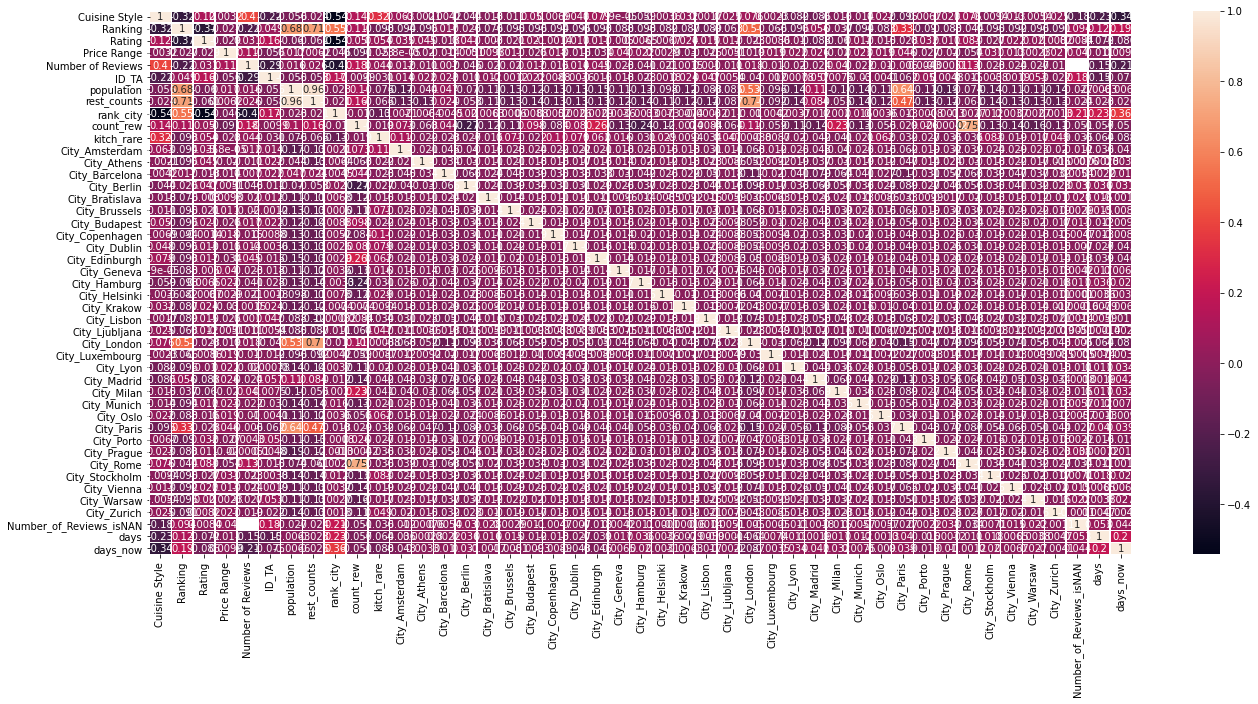

In [43]:
fig, ax = plt.subplots(figsize=(22, 10))
sns.heatmap(df.drop(kitches_by_350, axis=1).corr(), annot=True, linewidths=.5, ax=ax)

Удалим столбцы


In [44]:
df.drop(selected_dtype_obj, axis=1, inplace=True)
df.drop('Ranking', axis=1, inplace=True)

In [45]:
# Смотрим на пропущенные значения
df.isnull().sum()

Cuisine Style                 0
Rating                        0
Price Range                   0
Number of Reviews          2543
ID_TA                         0
                           ... 
City_Warsaw                   0
City_Zurich                   0
Number_of_Reviews_isNAN       0
days                          0
days_now                      0
Length: 93, dtype: int64

In [46]:
#заполним Number of Reviews средним значением
df['Number of Reviews'].fillna(df['Number of Reviews'].mean(), inplace=True) # заполнить 0 и посм МАЕ

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [47]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Rating'], axis = 1)
y = df['Rating']

In [48]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [49]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [50]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [51]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [52]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20035199999999997


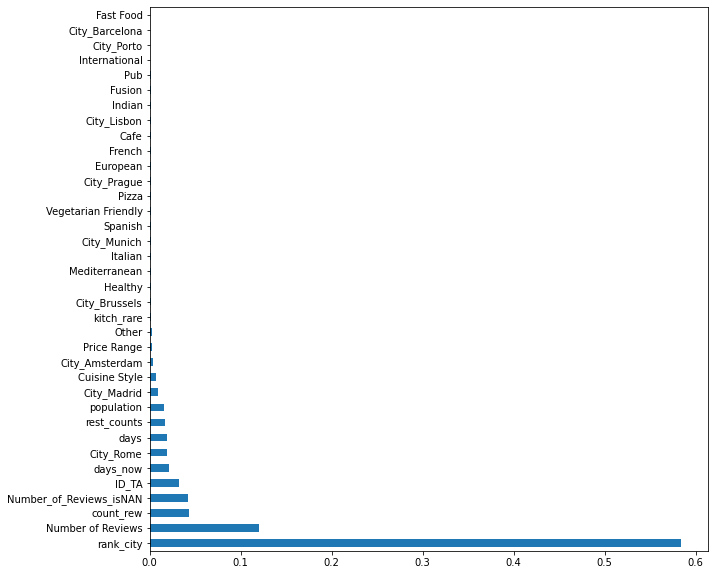

In [53]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(36).plot(kind='barh')